# Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Loading the data

In [3]:
folder = "/kaggle/input/ftml-dataset/regression"
X_test = np.load(os.path.join(folder, "X_test.npy"))
y_test = np.load(os.path.join(folder, "y_test.npy"))
X_train = np.load(os.path.join(folder, "X_train.npy"))
y_train = np.load(os.path.join(folder, "y_train.npy"))

print("size of the dataset:", len(y_train))
print("number of features:", len(X_train[0]))

size of the dataset: 200
number of features: 200


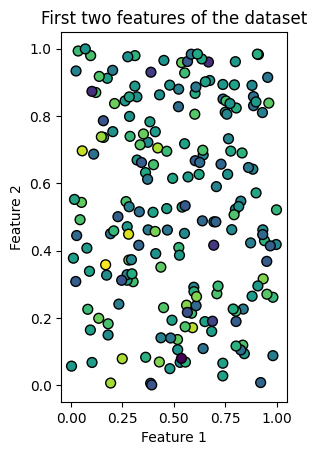

In [3]:
plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('First two features of the dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

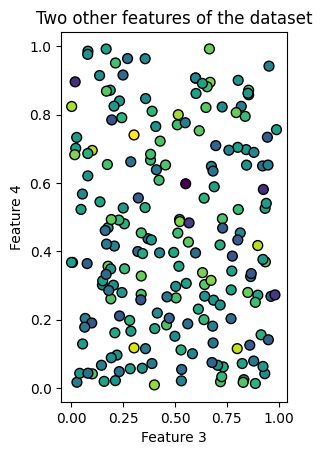

In [4]:
plt.subplot(1,2,1)
plt.scatter(X_train[:,2], X_train[:,3], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('Two other features of the dataset')
plt.xlabel('Feature 3')
plt.ylabel('Feature 4')

plt.show

# First method

### By following the graph of the methods seen in class, I started by trying to use a Ridge Regression.

In [4]:
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [7]:
clf = Ridge(alpha=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

0.716076652278387


### Let's try to get a better result by finding the best parameter

In [10]:
ridge = Ridge()
param_grid = {'alpha': np.logspace(-4, 4, 50)}

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_ridge = grid_search.best_estimator_
y_pred = best_ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f"Best Ridge alpha: {grid_search.best_params_['alpha']}")
print(f"Ridge Regression R2 score: {r2}")

Best Ridge alpha: 0.8286427728546842
Ridge Regression R2 score: 0.719464961959366


### Even after finding the best parameter, the results are still not good enough. Another method might be more accurate.

# Second method

### Another recommended method was the SVR method with linear kernel

In [60]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from scipy.optimize import minimize
from bayes_opt import BayesianOptimization

### The first tests were not very effective, but selecting features using RFE seemed to improve the score. The C of 0.8 is the results of a few tries.

In [61]:
svr = SVR(kernel='linear', C=0.8, gamma='scale')
rfe = RFE(estimator=svr, n_features_to_select=50, step=1)
rfe.fit(X_train, y_train.ravel())

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

### The results were still poor, so a parameter optimization was needed. 

In [45]:
svr = SVR(kernel='linear', C=0.8, gamma='scale')
rfe = RFE(estimator=svr, n_features_to_select=50, step=1)
rfe.fit(X_train, y_train.ravel())

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [52]:
def svr_cv(C, gamma):
    model = SVR(C=C, gamma=gamma, kernel='linear')
    val = cross_val_score(model, X_train_rfe, y_train.ravel(), cv=5, scoring='r2').mean()
    return val

pbounds = {'C': (0.1, 50), 'gamma': (1e-5, 1e-1)}
optimized = BayesianOptimization(f=svr_cv, pbounds=pbounds, random_state=13)
optimized.maximize(init_points=5, n_iter=20)
params = optimized.max['params']
best_C = params['C']
best_gamma = params['gamma']

print(f"C={best_C}, gamma={best_gamma}")

+--------+----------+-------+----------+
|  iter  |  target  |   C   |  gamma   |
+--------+----------+-------+----------+
|   1    |  0.9475  | 38.91 | 0.02376  |
|   2    |  0.9471  | 41.23 | 0.09658  |
|   3    |  0.9472  | 48.63 | 0.04535  |
|   4    |  0.947   | 30.49 | 0.07755  |
|   5    |  0.9472  | 32.12 |  0.0722  |
|   6    |  0.9473  | 41.91 | 0.006135 |
|   7    |  0.9475  | 34.09 |  0.0254  |
|   8    |  0.9471  | 23.27 | 0.06734  |
|   9    |  0.9474  | 35.81 | 0.09113  |
|   10   |  0.9474  | 49.82 | 0.06026  |
|   11   |  0.9474  | 38.66 | 0.07252  |
|   12   |  0.9474  | 39.2  |  0.0879  |
|   13   |  0.9474  | 34.53 | 0.03722  |
|   14   |  0.9471  | 33.65 | 0.08781  |
|   15   |  0.9475  | 34.27 | 0.09032  |
|   16   |  0.9471  | 35.57 | 0.04886  |
|   17   |  0.9473  | 36.14 |   0.1    |
|   18   |  0.9473  | 39.56 | 0.006514 |
|   19   |  0.9473  | 49.41 | 0.09433  |
|   20   |  0.9473  | 36.79 | 0.002112 |
|   21   |  0.9472  | 17.23 | 0.03681  |
|   22   |  0.94

### So from now on, I will keep :

In [56]:
best_C= 4.209291861662886
best_gamma= 0.027163974176688224

### More improvements were needed. I came across an example that used both rdb and linear kernels, so I tried it out. It was the best results I had, and more than 0.88 so I kept this version :

In [57]:
svr_lin = SVR(kernel='linear', C=best_C, gamma=best_gamma)
svr_rbf = SVR(kernel='rbf', C=best_C, gamma=best_gamma)
svr_lin.fit(X_train_rfe, y_train.ravel())
svr_rbf.fit(X_train_rfe, y_train.ravel())

y_pred_svr_lin = svr_lin.predict(X_test_rfe)
y_pred_svr_rbf = svr_rbf.predict(X_test_rfe)

In [58]:
def objective(param):
    w_lin, w_rbf = param
    y_pred_blend = (w_lin * y_pred_svr_lin) + (w_rbf * y_pred_svr_rbf)
    return -r2_score(y_test, y_pred_blend)

def constraint_fun(w):
    return w[0] + w[1] - 1
constraints = {'type': 'eq', 'fun': constraint_fun}

res = minimize(objective, [0.5, 0.5], bounds=[(0, 1), (0, 1)], constraints=constraints)
best_weights = res.x

In [59]:
y_pred = (best_weights[0] * y_pred_svr_lin) + (best_weights[1] * y_pred_svr_rbf)
best_r2 = r2_score(y_test, y_pred)

print(f"Best R2 Score: {best_r2}")

Best R2 Score: 0.8838716691740057
